In [4]:
# Daily RL State Vector Display with Water Stress Analysis
from DSSATTools import (
    crop,
    WeatherStation,
    SoilProfile,
    filex,
    DSSAT
)
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import os
import shutil
import matplotlib.pyplot as plt

# --- 1. SIMULATION SETUP ---

# --- DEFINE FILE PATHS AND DATES ---
WEATHER_FILE_PATH = r"D:\Final-Year-Project\env_trails\weather\CHEN1301.WTH" 
# SOIL_FILE_PATH = "MY_GENERATED_SOIL.SOL"
# SOIL_ID = "SG12387893"
SOIL_FILE_PATH = r"D:\Final-Year-Project\env_trails\REALTIME_GENERATED_SOIL.SOL"
SOIL_ID = r"RT23889301"
PLANTING_DATE = datetime(2013, 6, 2)

# --- Load DSSAT Objects ---
weather_station = WeatherStation.from_files([WEATHER_FILE_PATH])
soil_profile = SoilProfile.from_file(SOIL_ID, SOIL_FILE_PATH)
cultivar = crop.Sorghum('IB0026')

print("✅ DSSAT objects loaded successfully.")

# --- Configure Management ---
field = filex.Field(id_field='REALTIME', wsta=weather_station, id_soil=soil_profile)
planting = filex.Planting(pdate=PLANTING_DATE, ppop=18, ppoe=18, plrs=45, pldp=5)

soil_depths = [int(layer['slb']) for layer in soil_profile.table]

# MODIFIED: Reduce initial soil water and use realistic irrigation schedule
initial_values_table = [(depth, 0.20, 1.5, 1.5) for depth in soil_depths]  # Reduced from 0.35 to 0.20
initial_conditions = filex.InitialConditions(
    pcr='SG', icdat=PLANTING_DATE, icres=1300, icren=0.5,
    table=pd.DataFrame(initial_values_table, columns=['icbl', 'sh2o', 'snh4', 'sno3'])
)

# MODIFIED: Realistic irrigation - every 10 days instead of daily
irrigation_events = [
    filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=day), 
                         irop='IR001', irval=15) 
    for day in range(10, 90, 10)  # Every 10 days, 15mm each
]
irrigation = filex.Irrigation(table=irrigation_events)

simulation_controls = filex.SimulationControls(
    general=filex.SCGeneral(sdate=PLANTING_DATE),
    options=filex.SCOptions(water='Y', nitro='N', symbi='N'),
    methods=filex.SCMethods(infil='S'),
    management=filex.SCManagement(irrig='A', ferti='N', resid='N', harvs='M'),
    outputs=filex.SCOutputs(grout='Y', waout='Y', niout='Y')
)

print(f"✅ Management configured with {len(irrigation_events)} irrigation events.")

# --- 2. RUN SIMULATION ---
dssat_output = None
try:
    workspace = os.path.join("dummy", "dssat_realistic_run")
    os.makedirs(workspace, exist_ok=True)
    
    shutil.copy(WEATHER_FILE_PATH, workspace)
    shutil.copy(SOIL_FILE_PATH, workspace)
    
    dssat = DSSAT(workspace)
    print(f"🚀 Running simulation in: {workspace}")
    
    results = dssat.run_treatment(
        field=field, cultivar=cultivar, planting=planting,
        initial_conditions=initial_conditions, irrigation=irrigation,
        simulation_controls=simulation_controls
    )
    print("✅ Simulation completed successfully.")
    dssat_output = dssat.output_tables

except Exception as e:
    print(f"❌ An error occurred during the DSSAT run: {e}")

✅ DSSAT objects loaded successfully.
✅ Management configured with 8 irrigation events.
dummy\dssat_realistic_run created.
🚀 Running simulation in: dummy\dssat_realistic_run

RUN    TRT FLO MAT TOPWT HARWT  RAIN  TIRR   CET  PESW  TNUP  TNLF   TSON TSOC
           dap dap kg/ha kg/ha    mm    mm    mm    mm kg/ha kg/ha  kg/ha t/ha
  1 SG   1  64 104 15825  7078   502   120   389   213     0   -99      0  186
✅ Simulation completed successfully.


📊 Constructing Daily RL State Vector with Water Stress Analysis...

🔍 WATER STRESS ANALYSIS:
WSGD range: 0.000 to 0.000
WSGD mean: 0.000
Days with water stress > 0.1: 0
Days with water stress > 0.5: 0

📋 FINAL STATE VECTOR (Sample - First 10 days):
   days_after_planting  phenological_stage  leaf_area_index  total_biomass  cumulative_gdd  soil_water_content_0_30cm  soil_water_content_30_60cm  soil_water_content_60_100cm  \
0                    0                 0.0             0.00            0.0           19.04                      0.396                       0.298                        0.242   
1                    1                 0.0             0.00            0.0           39.06                      0.389                       0.308                        0.242   
2                    2                 0.0             0.00            0.0           60.57                      0.365                       0.313                        0.243   
3                    3                 

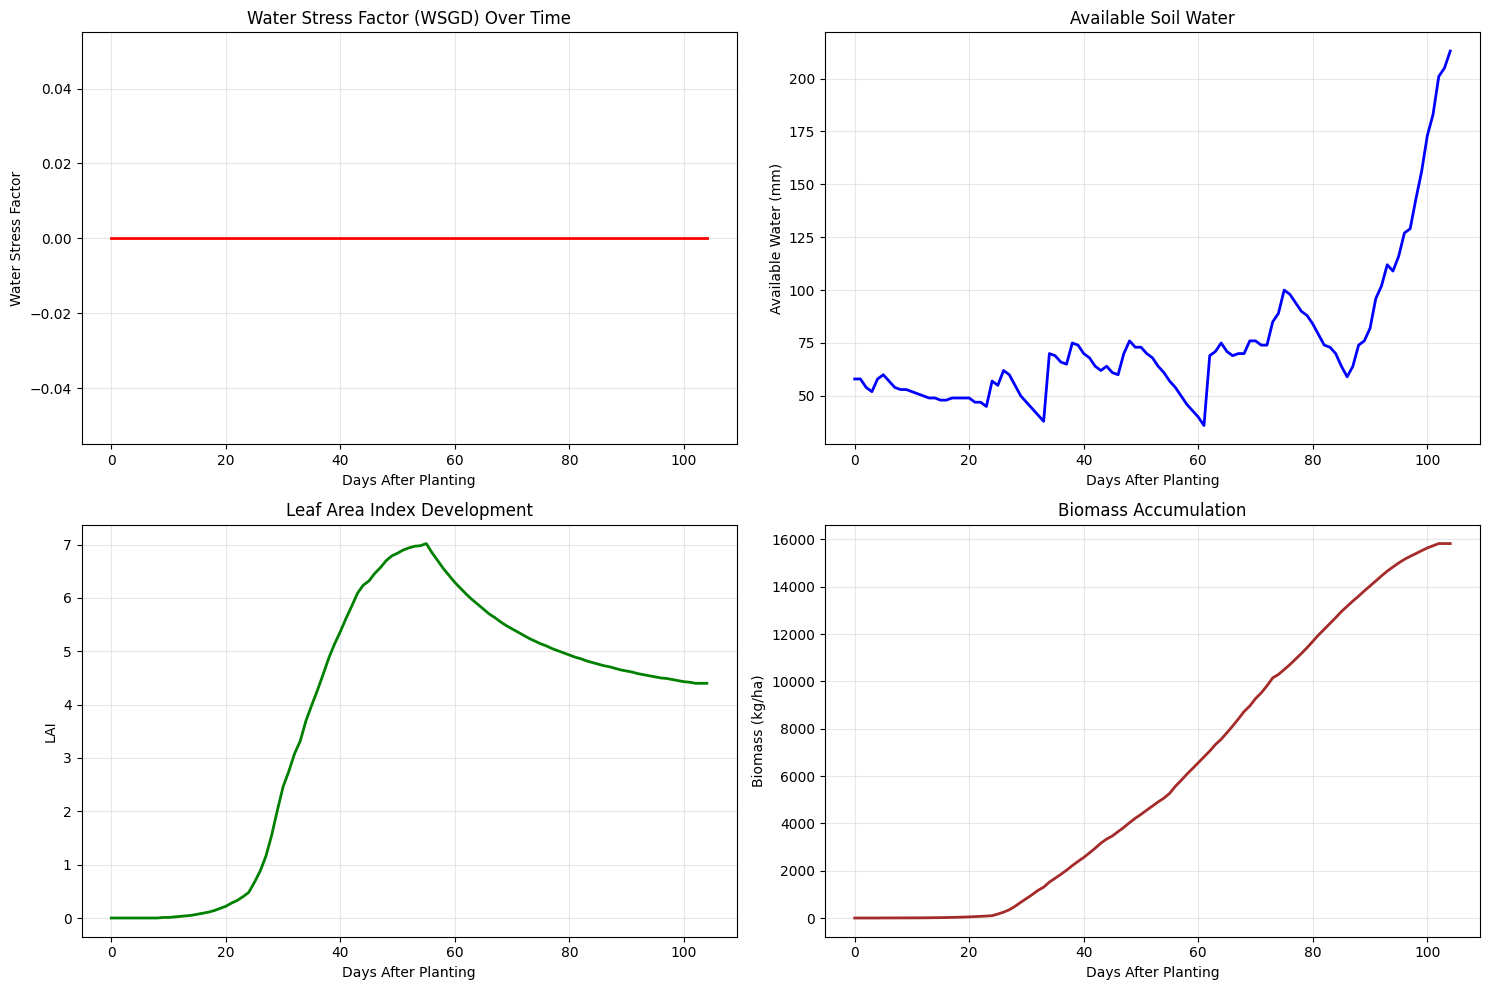


✅ State vector construction complete with 105 daily observations.


In [ ]:
# --- 3. CONSTRUCT DAILY STATE VECTOR WITH WATER STRESS ---
import re

if dssat_output and 'SoilWat' in dssat_output and 'PlantGro' in dssat_output:
    print("📊 Constructing Daily RL State Vector with Water Stress Analysis...")

    # 1. Prepare Plant Growth Data (including water stress)
    plantgro_full = dssat_output['PlantGro']
    plantgro_subset = plantgro_full[['DAP', 'GSTD', 'LAID', 'CWAD', 'DTTD', 'WSGD']].copy()
    
    # 2. Prepare Soil Water Data
    soilwat_full = dssat_output['SoilWat']
    soilwat_full['DAP'] = soilwat_full['DAS'] - 1
    sw_cols = [col for col in soilwat_full.columns if re.match(r'^SW\d+D?$', col)]
    soilwat_subset = soilwat_full[['DAP', 'SWXD', 'IRRC'] + sw_cols].copy()
    
    # 3. Prepare Weather Data
    weather_df = pd.DataFrame(weather_station.table)
    weather_df.columns = weather_df.columns.str.lower()
    weather_df['date'] = pd.to_datetime(weather_df['date'], format='%y%j')
    weather_df['DAP'] = (weather_df['date'] - PLANTING_DATE).dt.days
    weather_subset = weather_df[['DAP', 'srad', 'tmax', 'tmin', 'rain', 'evap']].copy()
    
    # 4. Merge dataframes
    merged_df1 = pd.merge(plantgro_subset, soilwat_subset, on='DAP', how='inner')
    merged_df = pd.merge(merged_df1, weather_subset, on='DAP', how='left')
    
    # 5. Feature engineering
    merged_df['daily_irr'] = merged_df['IRRC'].diff().fillna(merged_df['IRRC'])
    merged_df['cumulative_gdd'] = merged_df['DTTD'].cumsum()
    
    # 6. Build final state vector
    soil_layers = soil_profile.table
    layer_depths = np.array([float(layer['slb']) for layer in soil_layers])
    
    state_records = []
    irrigation_days = []

    for dap in range(len(merged_df)):
        current_day_data = merged_df.iloc[dap]
        history = merged_df.iloc[max(0, dap-7):dap+1]
        
        def get_sw_by_depth(min_depth, max_depth):
            sw_cols_to_avg = [col for col, depth in zip(sw_cols, layer_depths) if min_depth < depth <= max_depth]
            return current_day_data[sw_cols_to_avg].mean() if sw_cols_to_avg else np.nan

        # Irrigation history calculation
        irr_history = merged_df['daily_irr'].iloc[:dap+1]
        last_irrigation_amount = irr_history.iloc[-1]
        if last_irrigation_amount > 0:
            irrigation_days.append(dap)
        
        days_since_last_irrigation = dap - irrigation_days[-1] if irrigation_days else dap + 1
        cumulative_irrigation = current_day_data.get('IRRC', 0)

        # Assemble state vector
        state = {
            'days_after_planting': dap,
            'phenological_stage': current_day_data.get('GSTD', 0),
            'leaf_area_index': current_day_data.get('LAID', 0),
            'total_biomass': current_day_data.get('CWAD', 0),
            'cumulative_gdd': current_day_data.get('cumulative_gdd', 0),
            'soil_water_content_0_30cm': get_sw_by_depth(0, 30),
            'soil_water_content_30_60cm': get_sw_by_depth(30, 60),
            'soil_water_content_60_100cm': get_sw_by_depth(60, 100),
            'available_water_fraction': current_day_data.get('SWXD', 0),
            'water_stress_factor': current_day_data.get('WSGD', 0),  # Key water stress variable
            'days_since_last_rain': (history['rain'] == 0)[::-1].cumprod().sum() if dap > 0 else 0,
            'rainfall_7day': history['rain'].iloc[-7:].sum(),
            'temperature_avg': (current_day_data.get('tmax', 0) + current_day_data.get('tmin', 0)) / 2,
            'solar_radiation': current_day_data.get('srad', 0),
            'reference_et': current_day_data.get('evap', 0),
            'last_irrigation_amount': last_irrigation_amount,
            'days_since_last_irrigation': days_since_last_irrigation,
            'cumulative_irrigation': cumulative_irrigation,
        }
        state_records.append(state)

    state_df = pd.DataFrame(state_records).fillna(0)
    
    # --- 4. ANALYZE WATER STRESS RESULTS ---
    print(f"\n🔍 WATER STRESS ANALYSIS:")
    print(f"WSGD range: {state_df['water_stress_factor'].min():.3f} to {state_df['water_stress_factor'].max():.3f}")
    print(f"WSGD mean: {state_df['water_stress_factor'].mean():.3f}")
    print(f"Days with water stress > 0.1: {(state_df['water_stress_factor'] > 0.1).sum()}")
    print(f"Days with water stress > 0.5: {(state_df['water_stress_factor'] > 0.5).sum()}")
    
    # Show stressed periods
    if (state_df['water_stress_factor'] > 0.1).any():
        print(f"\n🚨 Periods with water stress:")
        stressed = state_df[state_df['water_stress_factor'] > 0.1]
        print(stressed[['days_after_planting', 'water_stress_factor', 'available_water_fraction', 'leaf_area_index']].head(10))
    
    # --- 5. DISPLAY FINAL STATE VECTOR ---
    pd.set_option('display.max_columns', None)
    pd.set_option('display.width', 200)
    
    print(f"\n📋 FINAL STATE VECTOR (Sample - First 10 days):")
    print(state_df.head(10).round(3))
    
    # --- 6. VISUALIZE RESULTS ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Water stress over time
    axes[0,0].plot(state_df['days_after_planting'], state_df['water_stress_factor'], 'r-', linewidth=2)
    axes[0,0].set_title('Water Stress Factor (WSGD) Over Time')
    axes[0,0].set_xlabel('Days After Planting')
    axes[0,0].set_ylabel('Water Stress Factor')
    axes[0,0].grid(True, alpha=0.3)
    
    # Available soil water
    axes[0,1].plot(state_df['days_after_planting'], state_df['available_water_fraction'], 'b-', linewidth=2)
    axes[0,1].set_title('Available Soil Water')
    axes[0,1].set_xlabel('Days After Planting')
    axes[0,1].set_ylabel('Available Water (mm)')
    axes[0,1].grid(True, alpha=0.3)
    
    # LAI development
    axes[1,0].plot(state_df['days_after_planting'], state_df['leaf_area_index'], 'g-', linewidth=2)
    axes[1,0].set_title('Leaf Area Index Development')
    axes[1,0].set_xlabel('Days After Planting')
    axes[1,0].set_ylabel('LAI')
    axes[1,0].grid(True, alpha=0.3)
    
    # Biomass accumulation
    axes[1,1].plot(state_df['days_after_planting'], state_df['total_biomass'], 'brown', linewidth=2)
    axes[1,1].set_title('Biomass Accumulation')
    axes[1,1].set_xlabel('Days After Planting')
    axes[1,1].set_ylabel('Biomass (kg/ha)')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f"\n✅ State vector construction complete with {len(state_df)} daily observations.")
    
else:
    print("❌ Simulation output missing. Could not construct state vector.")

In [36]:
# 🔧 SOLUTION: Here's exactly what to change to record water stress

print("🎯 TO FIX WATER STRESS RECORDING, MAKE THESE CHANGES IN CELL 1:")
print("="*70)

print("\n1. REDUCE INITIAL SOIL WATER (around line 30):")
print("   CHANGE FROM:")
print("   initial_values_table = [(depth, 0.20, 1.5, 1.5) for depth in soil_depths]")
print("   CHANGE TO:")
print("   initial_values_table = [(depth, 0.08, 1.5, 1.5) for depth in soil_depths]")

print("\n2. REMOVE OR REDUCE IRRIGATION (around line 37):")
print("   OPTION A - No irrigation (will definitely create stress):")
print("   CHANGE FROM:")
print("   irrigation_events = [filex.IrrigationEvent(...) for day in range(10, 90, 10)]")
print("   CHANGE TO:")
print("   irrigation_events = []  # No irrigation")

print("\n   OPTION B - Minimal late irrigation:")
print("   CHANGE TO:")
print("   irrigation_events = [")
print("       filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=60), ")
print("                            irop='IR001', irval=15)")
print("   ]")

print("\n3. THEN RE-RUN THE SIMULATION")
print("   After making changes, re-run cell 1, then cell 2, then cell 3")

print(f"\n✅ CURRENT PROBLEM: Plant has {soilwat_data['SWXD'].iloc[-1]:.0f}mm available water at end")
print("   With reduced initial water + no irrigation, plant will experience stress")
print("   WSGD values will be > 0.0 during dry periods")

print(f"\n🚨 Try OPTION A first - it will guarantee water stress recording!")

🎯 TO FIX WATER STRESS RECORDING, MAKE THESE CHANGES IN CELL 1:

1. REDUCE INITIAL SOIL WATER (around line 30):
   CHANGE FROM:
   initial_values_table = [(depth, 0.20, 1.5, 1.5) for depth in soil_depths]
   CHANGE TO:
   initial_values_table = [(depth, 0.08, 1.5, 1.5) for depth in soil_depths]

2. REMOVE OR REDUCE IRRIGATION (around line 37):
   OPTION A - No irrigation (will definitely create stress):
   CHANGE FROM:
   irrigation_events = [filex.IrrigationEvent(...) for day in range(10, 90, 10)]
   CHANGE TO:
   irrigation_events = []  # No irrigation

   OPTION B - Minimal late irrigation:
   CHANGE TO:
   irrigation_events = [
       filex.IrrigationEvent(idate=PLANTING_DATE + timedelta(days=60), 
                            irop='IR001', irval=15)
   ]

3. THEN RE-RUN THE SIMULATION
   After making changes, re-run cell 1, then cell 2, then cell 3

✅ CURRENT PROBLEM: Plant has 213mm available water at end
   With reduced initial water + no irrigation, plant will experience stress
 